## 特征挑选
分别用IV值和随机森林等进行特征选择

In [153]:
import pandas as pd
from numpy import log
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm


In [154]:
pd.options.display.max_columns = None
df = pd.read_csv(r"F:\文档\python\load_data\prosper_dataset_task1.csv",encoding="utf-8",engine="python")

df.describe()
print("本数据集有{}行，{}列".format(df.shape[0],df.shape[1]))
df.describe()
# 方差较大的creditscore，recorded_history，totalcreditlinespast7years，term，openrevolvingmonthlypayment，amountdelinquent，revolvingcreditbalance，loancurrentdaysdelinquent
# availablebankcardcredit，totalprosperpaymentsbilled，ontimeprosperpayments，prosperprincipalborrowed，prosperprincipaloutstanding，scorexchangeattimeoflisting，loanmonthssinceorigination

本数据集有84984行，85列


,term,loanstatus,borrowerapr,borrowerrate,lenderyield,estimatedeffectiveyield,estimatedloss,estimatedreturn,prosperrating,prosperscore,currentcreditlines,opencreditlines,totalcreditlinespast7years,openrevolvingaccounts,openrevolvingmonthlypayment,inquirieslast6months,totalinquiries,currentdelinquencies,amountdelinquent,delinquencieslast7years,publicrecordslast10years,publicrecordslast12months,revolvingcreditbalance,availablebankcardcredit,totaltrades,tradesneverdelinquent,tradesopenedlast6months,debttoincomeratio,totalprosperloans,totalprosperpaymentsbilled,ontimeprosperpayments,prosperpaymentslessthanonemonthlate,prosperpaymentsonemonthpluslate,prosperprincipalborrowed,prosperprincipaloutstanding,scorexchangeattimeoflisting,loancurrentdaysdelinquent,loanfirstdefaultedcyclenumber,loanmonthssinceorigination,loanoriginalamount,monthlyloanpayment,lp_customerpayments,lp_customerprincipalpayments,lp_interestandfees,lp_servicefees,lp_collectionfees,lp_grossprincipalloss,lp_netprincipalloss,lp_nonprincipalrecoverypayments,percentfunded,recommendations,investmentfromfriendscount,investmentfromfriendsamount,investors,bankcardutilization_level__1,bankcardutilization_level__2,bankcardutilization_level__3,bankcardutilization_level__4,incomerange_level__1,incomerange_level__2,incomerange_level__3,incomerange_level__4,incomerange_level__5,loans_before,employmentstatus_free_work,employmentstatus_no_show_status,employmentstatus_no_work,employmentstatus_working,recorded_history,creditscore,未说明,债务整合,业务,学生使用,生育,整容手术,家用,大采购,医疗,交通工具,RV,税收,假期,结婚贷款
count,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.00000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000
mean,42.475854,1.442354,0.226597,0.195971,0.185966,0.168675,0.080326,0.101566,4.070590,5.950144,10.50766,9.527570,27.653570,7.385473,430.534548,0.964393,4.291784,0.322390,949.976678,3.657983,0.284948,0.009155,17931.141285,11403.965111,23.925927,0.905904,0.729561,0.236492,0.341064,5.677351,5.510931,0.154100,0.012320,2043.662712,680.297810,-0.886849,36.656606,1.066048,16.073261,9075.893403,291.705773,3670.908158,2629.046679,1041.861479,-54.635112,-8.193418,375.733193,367.382169,7.635276,0.998101,0.017662,0.008096,4.398265,68.399110,0.128307,0.268627,0.301504,0.255036,0.054916,0.284936,0.302080,0.170797,0.179104,0.233632,0.056540,0.044785,0.012002,0.886673,17.414819,708.908359,0.000235,0.626541,0.062541,0.003295,0.111091,0.001071,0.080851,0.010308,0.041396,0.030982,0.000612,0.010414,0.009037,0.011626
std,11.634602,0.846847,0.079947,0.074656,0.074656,0.068415,0.046730,0.143184,1.672466,2.374669,5.31737,4.931477,13.264897,4.515907,425.740226,1.399771,3.828965,1.111904,7414.844118,9.345156,0.648154,0.125892,31349.186724,18609.686870,11.606478,0.121399,0.992479,0.313200,0.726136,14.031185,13.672935,1.271985,0.282873,5193.518716,2214.081446,22.538249,150.532479,4.275612,13.946047,6287.177834,186.674900,4233.084503,3621.090281,1135.496121,59.709184,75.128253,1719.782305,1699.242565,119.073775,0.020726,0.188214,0.109900,118.384745,95.28756

### 查看label分布（样本是否平衡）

2    0.677586
0    0.235233
1    0.087181
Name: loanstatus, dtype: float64


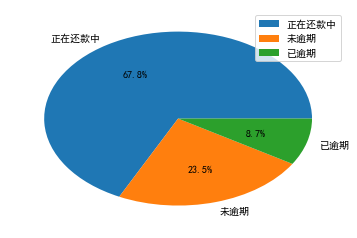

In [155]:
%matplotlib inline

mpl.rcParams["font.sans-serif"] = ["SimHei"]
print(df.loanstatus.value_counts(1))
labels = ["正在还款中","未逾期","已逾期"]
plt.pie(df.loanstatus.value_counts(),labels=labels,autopct="%3.1f%%")
plt.legend()
# 预测集占比也太大了吧····

### 特征工程
1. 用VIF方差膨胀因子计算各个特征之间的多重共线性
2. 分别用IV值和随机森林等进行特征选择

In [156]:
# 禁止显示警告
import warnings 
warnings.filterwarnings('ignore')

# opencreditlines和currentcreditlines可以衍生出一个新特征当前打开信用额度的比例
df["opencreditlines_ratio"] = df["opencreditlines"]/(df["currentcreditlines"]+1)

# 观察vif值，多重共线性较为严重，从特征的合理性和有效性来看，我们删除可被替代的特征
# 方差膨胀因子较大的有：
# borrowerrate借款人的贷款利率
# lenderyield贷方在贷款上的收益。贷方收益等于贷款利率减去服务费。
# borrowerapr借款人的贷款年利率(APR)。
# lp_grossprincipalloss从贷款中扣除的总额。
# lp_netprincipalloss收回后仍未收回的本金
# incomerange_level__3 收入水平3
# incomerange_level__2 收入水平2
# incomerange_level__5 收入水平5
# incomerange_level__4 收入水平4
# prosperrating 在创建清单时分配的Prosper评级为:0 - N/A、1 - HR、2 - E、3 - D、4 - C、5 - B、6 - A、7 - AA。适用于2009年7月以后发放的贷款。
# estimatedloss 估计损失是估计的冲销本金损失
# loanoriginalamount 贷款的发放金额
# opencreditlines 在提取信用档案时，开放信用额度的数量。
# currentcreditlines 在提取信用档案时，当前信用额度的数量。
# incomerange_level__1 收入水平1
# monthlyloanpayment 计划每月的贷款支付。
# totaltrades 有多少交易额度被打开过
# lp_servicefees 已投资于该贷款的投资者所支付的累积服务费
# totalprosperloans 在他们创建这个列表时，Prosper贷款的借款人数量
# totalcreditlinespast7years 在过去7年的信用额度，在信用档案被删除时。
# estimatedeffectiveyield 有效收益率等于借款人利率(i)减去服务费利率，(ii)减去冲销的预计未收利息，(iii)加上预计已收滞纳金。
# 分类变量虚拟化之后的特征也会出现多重共线性，删除其中一个即可，但考虑到不影响模型效果，不做删除处理
df.drop(columns=["borrowerrate","lenderyield","lp_grossprincipalloss","estimatedloss",
                 "loanoriginalamount","totalprosperloans","opencreditlines","borrowerapr","incomerange_level__3","loancurrentdaysdelinquent",'loancurrentdaysdelinquent','lp_servicefees','openrevolvingmonthlypayment'],axis=1,inplace=True)

# 再次计算VIF
# 运行一个多元回归
features = "+".join(df.columns.drop("loanstatus"))
features
y,x = dmatrices("loanstatus~"+features,df,return_type="dataframe")
# 计算VIF因子。
vif = pd.DataFrame()

vif["features"] = x.columns
vif["vif factor"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
# 检查每个预测变量的因素，如果VIF在5-10之间，可能存在多效性，应该考虑删除该变量。
vif.round(1)[vif["vif factor"]>5].sort_values(by="vif factor",ascending =False)

,features,vif factor
54,employmentstatus_no_show_status,inf
55,employmentstatus_no_work,inf
71,假期,inf
70,税收,inf
69,RV,inf
68,交通工具,inf
67,医疗,inf
66,大采购,inf
65,家用,inf
64,整容手术,inf


### 计算特征的正样本率，负样本率，WOE

In [157]:
def calcWOE(dataset, col, target):
    """
    计算特征的正样本率，负样本率，WOE（weight of evidence）
    :param dataset: 数据集
    :param col: 计算WOE的特征名称
    :param target: 目标变量名称
    :return: 特征正样本率，负样本率，WOE的数据框
    """
    # 对特征进行统计分组
    # print(dataset.groupby(col)[col].count())# 特征的每种唯一值的数量，返回序列
    subdata = pd.DataFrame(dataset.groupby(col)[col].count())# 将序列转换为数据框

    # 每个分组中响应客户的数量
    suby = pd.DataFrame(dataset.groupby(col)[target].sum())
    # subdata 与 suby 的拼接,data中体现特征的每个值得数量和逾期数量
    data = pd.DataFrame(pd.merge(subdata, suby, how='left', left_index=True, right_index=True))
    # 相关统计，总共的样本数量total，响应客户总数y_total，未响应客户数量n_total
    y_total = data[target].sum()
    total = data[col].sum()
    n_total = total - y_total

    # WOE公式
    # 计算每个特征数据框的正负样本率
    data["overdue"] = data.apply(lambda x:round(x[target]/y_total, 100), axis=1)
    data["ontime"] = data.apply(lambda x:round((x[col] - x[target])/n_total, 100), axis=1)
    # 计算特征每组WOE = ln(正样本率/负样本率)
    # 不是用ln()？?
    data["WOE"] = data.apply(lambda x:log(x.overdue / x.ontime), axis=1)
    return data.loc[:, ["overdue", "ontime", "WOE"]]


### 计算特征的IV值

In [158]:
def calcIV(dataset):
    """
    计算特征的IV值
    :param dataset: 包含特征正样本率，负样本率，WOE的数据框
    :return: 每个特征的单一IV值
    """
    # 特征每组的IV值=（正样本率-负样本率）*WOE
    dataset["IV"] = dataset.apply(lambda x:(x["overdue"] - x["ontime"]) * x["WOE"], axis=1)
    # 计算特征的IV
    IV = sum(dataset["IV"])
    return IV


In [159]:
y = df.loanstatus
# 删除目标变量loanstatus
x= df.drop(labels='loanstatus', axis=1)

# col_list = [col for col in data.drop(labels='status', axis=1)]
col_list = [col for col in x]
data_IV = pd.DataFrame()
iv_feature = []

for col in col_list:
    # 计算每个特征的正样本率，负样本率，WOE
    col_WOE = calcWOE(df, col, "loanstatus")
    # 删除nan、inf、-inf
    col_WOE = col_WOE[~col_WOE.isin([np.nan, np.inf, -np.inf]).any(1)]
    # 计算每个特征的IV
    col_IV = calcIV(col_WOE)
    # 如果IV值超过0.1，说明相关性较大，保存每个特征的IV值到data_IV
    if col_IV >= 0.1:
        data_IV[col] = [col_IV]
        # fea_iv储存相关性较强的特征名称
        iv_feature.append(col)

data_IV.to_csv('iv_feature.csv', index=0)
print("筛选出相关性不小于0.1的%s个特征"%len(iv_feature),iv_feature)

筛选出相关性不小于0.1的10个特征 ['estimatedeffectiveyield', 'estimatedreturn', 'revolvingcreditbalance', 'availablebankcardcredit', 'loanmonthssinceorigination', 'monthlyloanpayment', 'lp_customerpayments', 'lp_customerprincipalpayments', 'lp_interestandfees', 'investors']


### 使用随机森林进行特征选择

In [160]:
x.replace([np.nan, np.inf, -np.inf],0,inplace=True)# 随机森林训练时nan或者inf会引起报错，所以将无效值转换为0

# 在用随机森林模型评估每个特征的贡献性之前应当先拆分训练集和测试集的，但是因为数据量太少就省去了拆分步骤
clf = RandomForestClassifier(random_state=2018)
clf.fit(x, y)
# print(clf.feature_importances_)# 随机森林模型评估每个特征的重要性
importance = pd.Series(clf.feature_importances_, index=x.columns).sort_values(ascending=False)
# 筛选重要性较高的前40个特征
forest_feature = importance[: 25].index.tolist()
print(forest_feature)

['lp_customerprincipalpayments', 'loanmonthssinceorigination', 'lp_customerpayments', 'loanfirstdefaultedcyclenumber', 'lp_interestandfees', 'investors', 'monthlyloanpayment', 'lp_netprincipalloss', 'estimatedreturn', 'estimatedeffectiveyield', 'lp_collectionfees', 'term', 'prosperrating', 'revolvingcreditbalance', 'availablebankcardcredit', 'prosperscore', 'debttoincomeratio', 'recorded_history', 'totalcreditlinespast7years', 'opencreditlines_ratio', 'totaltrades', 'creditscore', 'currentcreditlines', 'totalinquiries', 'openrevolvingaccounts']


## 筛选特征
结合IV值和随机森林筛选出预测能力较好的特征

In [161]:
# IV筛选出13个相关性较好的特征和随机森林筛选出来的25个特征的并集
combine_feature = list(set(forest_feature)|set(iv_feature))
print(len(combine_feature),combine_feature)
pre_set = df.query('loanstatus == 2')[combine_feature]
combine_feature.append("loanstatus")
data = df.query('loanstatus != 2')[combine_feature]

print('预测集大小：',pre_set.shape)
print('训练集大小：',data.shape)
df.to_csv(r"F:\文档\python\load_data\prosper_dataset_task2.csv",index=False)
data.to_csv(r"F:\文档\python\load_data\prosper_data_task2.csv",index=False)
pre_set.to_csv(r"F:\文档\python\load_data\prosper_pre_task2.csv",index=False)


25 ['lp_customerpayments', 'lp_collectionfees', 'term', 'prosperscore', 'lp_customerprincipalpayments', 'revolvingcreditbalance', 'debttoincomeratio', 'totalcreditlinespast7years', 'loanfirstdefaultedcyclenumber', 'availablebankcardcredit', 'opencreditlines_ratio', 'monthlyloanpayment', 'lp_netprincipalloss', 'openrevolvingaccounts', 'estimatedeffectiveyield', 'totaltrades', 'lp_interestandfees', 'loanmonthssinceorigination', 'currentcreditlines', 'estimatedreturn', 'creditscore', 'totalinquiries', 'investors', 'prosperrating', 'recorded_history']
预测集大小： (57584, 25)
训练集大小： (27400, 26)


结合结果筛选出来的特征有： 
1. estimatedeffectiveyield 有效收益率,等于借款人利率(i)减去服务费利率，(ii)减去冲销的预计未收利息，(iii)加上预计已收滞纳金。
2. estimatedreturn 估计收益率，在清单创建时分配给它的估计返回值。估计收益率是估计有效收益率与估计损失率之间的差额。
3. openrevolvingmonthlypayment 每月支付还款
4. revolvingcreditbalance 在信用档案被提取时的循环信贷美元，是个人消费者和企业可用的两种基本信贷形式之一，通常作为信用卡或信用额度使用。
5. availablebankcardcredit 在提取信用档案时，通过银行卡的可用信用总额。
6. loanmonthssinceorigination 从贷款发放距离现在的月数
7. monthlyloanpayment 每月的贷款支付
8. lp_customerpayments 预先冲销借款人就贷款所支付的累积总款项。如果贷款已经冲销，这个值将不包括任何回收。
9. lp_customerprincipalpayments 借款人对贷款的累计本金支付
10. lp_interestandfees 借款人支付的累计利息和费用
11. lp_servicefees 已投资于该贷款的投资者所支付的累积服务费
12. investors 为贷款提供资金的投资者数量
13. term 还款期数
14. prosperscore 自定义风险评分 1-10
15. debttoincomeratio 在信用档案被提取时借款人的债务收入比
16. loanfirstdefaultedcyclenumber 贷款优先违约周期数/贷款被冲销的周期。如果贷款没有冲销，则该值为空。
17. totalcreditlinespast7years 在过去7年的信贷额度数量，当时信贷概况被取消。
18. 生育 贷款用途为生育
19. totaltrades 在信用档案被撤销时，曾经开通的贸易额度数量。
20. prosperrating 最初的Prosper评级
21. recorded_history 第一次打开额度到本次贷款的时间间隔
22. loancurrentdaysdelinquent 拖欠的天数
23. opencreditlines_ratio 当前打开额度占总额度比例
24. lp_collectionfees 已投资该项贷款的投资者所支付的累计托收费用。
25. lp_netprincipalloss 本金在任何收回后仍未收回的本金。

发现有一些特征以及透露了是否逾期，比如loancurrentdaysdelinquent，需要删除
还有一些特征有重复特征
openrevolvingmonthlypayment 和 lp_customerprincipalpayments重复，删除openrevolvingmonthlypayment
lp_collectionfees 和 lp_servicefees，删除lp_servicefees
'loancurrentdaysdelinquent','lp_servicefees','openrevolvingmonthlypayment'

In [163]:
## 经过特征选择可以省去降维操作，不过可以对比特征选择和降维那种处理方式对之后建模效果更好
## 降维
print(df.shape)
# # (84984, 64)
from sklearn.decomposition import PCA


# df.to_csv(r"F:\文档\python\load_data\prosper_dataset_task2.csv",index=False)
# data.to_csv(r"F:\文档\python\load_data\prosper_data_task2.csv",index=False)
# pre_set.to_csv(r"F:\文档\python\load_data\prosper_pre_task2.csv",index=False)

# 拆分数据集
x = data.drop("loanstatus",axis=1)
y = data["loanstatus"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 2018)
pca=PCA(n_components=20).fit(x_train)
print(pca.explained_variance_ratio_)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)
print(x_train_pca)
print(x_test_pca)


(84984, 74)
[6.60955352e-01 2.96874130e-01 3.62669402e-02 4.96642997e-03
 9.15526750e-04 8.65241787e-06 6.15303968e-06 4.96146342e-06
 1.36251120e-06 2.41842333e-07 1.06645276e-07 4.78159156e-08
 3.55682403e-08 1.95172690e-08 1.64498528e-08 1.15763522e-08
 6.72434638e-09 3.13331583e-09 2.17749595e-09 4.65218953e-10]
[[ 2.62261484e+03  1.20222372e+04 -7.52024396e+03 ...  3.87731361e+00
  -1.13978876e+00 -1.10075767e-01]
 [ 2.04409396e+04 -1.62312305e+04 -6.69874832e+02 ...  2.07245916e+00
   1.97813218e+00  1.64706556e+00]
 [-1.52296509e+04 -7.47883577e+03  2.08038092e+03 ... -1.63711804e+00
   6.38734944e-01  7.61836863e-01]
 ...
 [-1.42092431e+04 -4.11220189e+03 -5.69901857e+03 ...  1.86046747e+00
   2.59879671e+00 -1.14510517e+00]
 [-1.46032350e+04 -5.94522660e+03 -1.38242875e+03 ... -1.90151008e-01
  -5.57237424e-02  3.20686795e-02]
 [-1.52800406e+04  1.69194875e+03  2.69448022e+02 ... -1.07027177e-01
  -2.38000766e+00 -3.05867776e-01]]
[[-1.75099567e+04 -7.33148524e+03 -1.84316520e